In [39]:
# %%
import pandas as pd
from helpers import hansard
import tqdm
# %%
experiment_folder = 'eval_06'
root_folder = hansard.rootFolder(experiment_folder)
# %%
df_probs_fn = root_folder + '/speeches_df_topics_probs.pkl'

# %%
print(f'load df from {df_probs_fn}')
speeches_df = pd.read_pickle(df_probs_fn)

load df from /home/azureuser/cloudfiles/code/data/processing/hansard/experiment/eval_06/speeches_df_topics_probs.pkl


In [40]:
speeches_df.head()

,date_time,chamber,parliament,session,period,page,name,name_id,party,in_gov,electorate,first_speech,context,context_title,context_type,speech_type,probs
0,1998-03-02 12:31:00,Reps,38,1,6,1,"Grace, Elizabeth, MP",ML6,LP,True,Lilley,0,debate,committees,committees,speech,"[4.855e-05, 4.358e-05, 4.383e-05, 4.766e-05, 4..."
1,1998-03-02 12:32:00,Senate,38,1,6,1,"Neal, Sen Belinda",B36,ALP,True,NSW,0,debate,social security legislation amendment (youth a...,bills,speech,"[1.877e-05, 1.684e-05, 1.694e-05, 1.842e-05, 1..."
2,1998-03-02 12:36:00,Reps,38,1,6,1,"Price, Roger, MP",QI4,ALP,True,Chifley,0,debate,committees,committees,speech,"[0.08475193, 4.02e-05, 0.09782998, 4.397e-05, ..."
3,1998-03-02 12:44:00,Reps,38,1,6,1,"Smith, Tony, MP",SK6,LP,True,Dickson,0,debate,committees,committees,speech,"[2.969e-05, 2.665e-05, 0.03988356, 2.914e-05, ..."
4,1998-03-02 12:52:00,Senate,38,1,6,1,"Carr, Sen Kim",AW5,ALP,True,VIC,0,debate,social security legislation amendment (youth a...,bills,speech,"[3.868e-05, 1.182e-05, 1.188e-05, 1.292e-05, 0..."


In [41]:
#! ls -lh /home/azureuser/cloudfiles/code/data/processing/hansard/experiment/20201003_1/

In [42]:
speeches_df.tail(5)

,date_time,chamber,parliament,session,period,page,name,name_id,party,in_gov,electorate,first_speech,context,context_title,context_type,speech_type,probs
346716,2020-09-03 17:42:00,Reps,46,1,4,0,"Porter, Christian, MP",208884,LP,False,Pearce,NaN,debate,adjournment,adjournment,speech,"[0.01087956, 0.00976534, 0.0098218, 0.01068079..."
346717,2020-09-03 17:45:00,Senate,46,1,4,0,"Chandler, Sen Claire",264449,LP,False,Tasmania,NaN,debate,adjournment,adjournment,speech,"[4.787e-05, 4.297e-05, 4.322e-05, 4.7e-05, 4.4..."
346718,2020-09-03 17:46:00,Reps,46,1,4,0,"Smith, Tony, MP",00APG,LP,False,Casey,NaN,debate,adjournment,adjournment,speech,"[0.00227676, 0.00204359, 0.0020554, 0.00223517..."
346719,2020-09-03 17:50:00,Senate,46,1,4,0,"McCarthy, Sen Malarndirri",122087,ALP,False,Northern Territory,NaN,debate,adjournment,adjournment,speech,"[0.00016458, 0.00014773, 0.17785507, 0.0001615..."
346720,2020-09-03 17:53:00,Senate,46,1,4,0,"Waters, Sen Larissa",192970,AG,False,Queensland,NaN,debate,adjournment,adjournment,speech,"[7.123e-05, 6.394e-05, 6.431e-05, 6.993e-05, 6..."


In [43]:
print('check that topics probs add up to 1 for each doc')
speeches_df.apply(lambda x: sum(x['probs']), axis='columns')

check that topics probs add up to 1 for each doc


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
346716    1.0
346717    1.0
346718    1.0
346719    1.0
346720    1.0
Length: 346721, dtype: float64

# KLD

In [44]:
from scipy.stats import entropy
import numpy as np


x, y = speeches_df.probs[0], speeches_df.probs[10]
kld1 = entropy(pk=x, qk=y)
print(kld1)

# entropy 0 -> two distributions are the same
kld2 = entropy(pk=x, qk=x)
print(kld2)

9.157829
0.0


# Novelty, Transcience, Resonance 

In [45]:
Nw = 150  # window of prior speeches
Tw = 150  # window of future speeches

novelty = list()
transience = list()
resonance = list()

We could index our data set by data_time column, and then treat it as a timeseries for plotting and anaytics

In [46]:
# NOTE: is set to run sample from 300,000 to the end


for i, x in tqdm.tqdm(enumerate(speeches_df.probs[300000:]), desc='Calculate Novelty, Transience and Resonance'):
    if i < Nw:
        # there is not enough previous items
        Ni = 0 # need to decide what to set novelt for early items when no history to compare with
    else:
        klds = list()
        for d in range(Nw):
            y = speeches_df.probs[i - d]
            k = entropy(pk=y, qk=x)  # flipped the order here so the divergence calc is in chron order
            klds.append(k)
        Ni = np.mean(klds)

    novelty.append(Ni)

    if i > len(speeches_df.probs) - Tw:
        Ti = 0
    else:
        klds = list()
        for d in range(Tw):
            y = speeches_df.probs[i + d]
            k = entropy(pk=x, qk=y)
            klds.append(k)
        Ti = np.mean(klds)

    transience.append(Ti)

    Ri = Ni - Ti
    resonance.append(Ri)

Calculate Novelty, Transience and Resonance: 46721it [11:05, 70.20it/s]


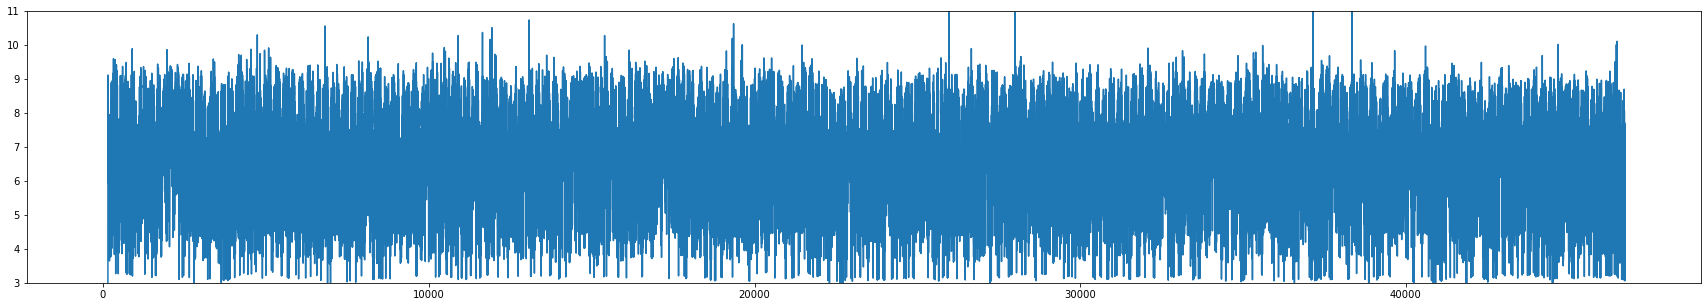

In [47]:
import matplotlib.pylab as plt
plt.figure(figsize=(30,5))
plt.ylim(3,11)
plt.plot(novelty)
plt.show()


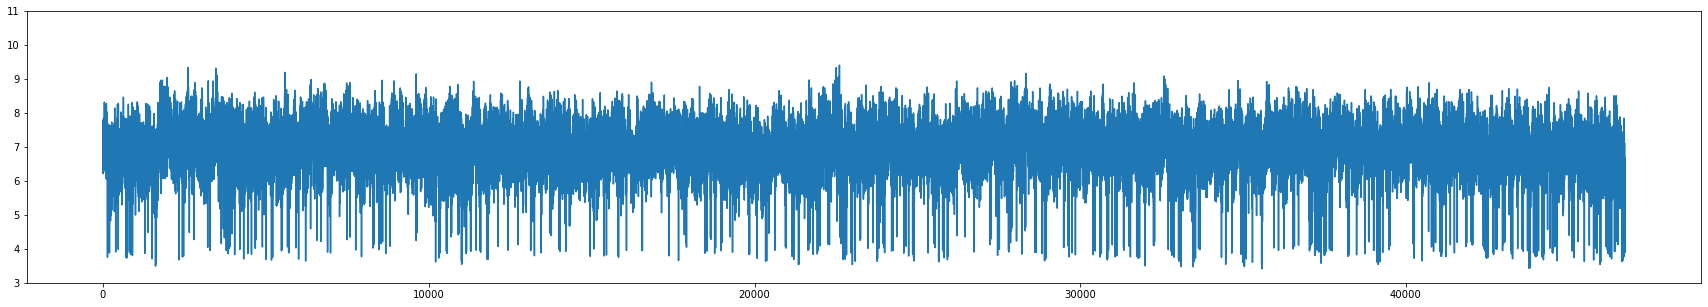

In [48]:
plt.figure(figsize=(30,5))
plt.ylim(3,11)
plt.plot(transience)
plt.show()


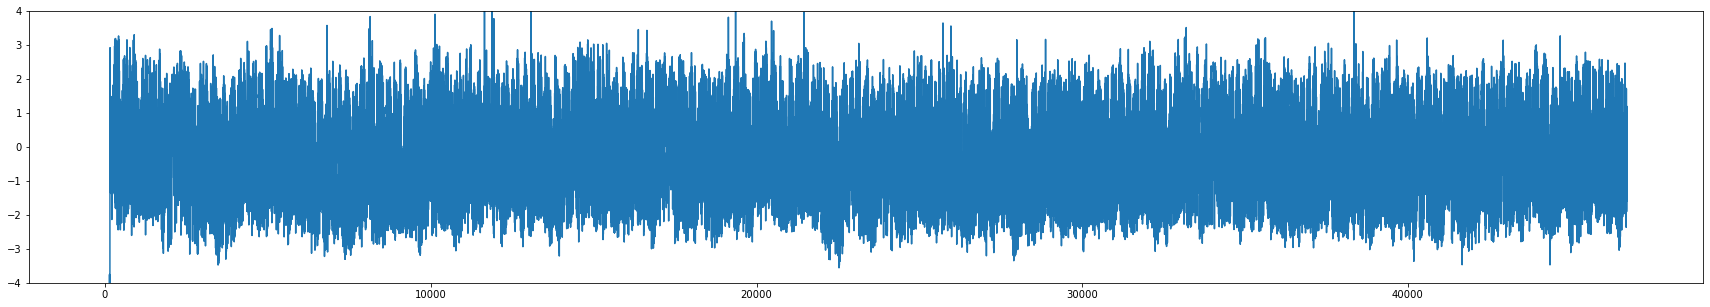

In [49]:
plt.figure(figsize=(30,5))
plt.ylim(-4,4)
plt.plot(resonance)
plt.show()


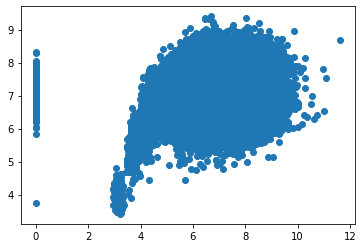

In [50]:
plt.scatter(x=novelty, y=transience)

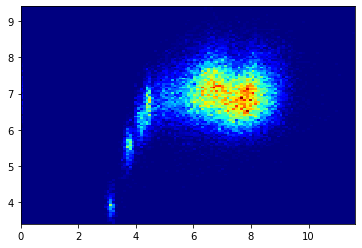

In [51]:
import matplotlib.pyplot as pyplot

p = pyplot.hist2d(x=novelty, y=transience, bins=(120, 120), cmap=plt.cm.jet)



In [13]:
len(novelty)

10000

In [14]:
len(transience)

10000

In [15]:
len(resonance)

10000

In [16]:
len(speeches_df.probs)

346721